(fin-edu:principles:sequence-risk)=
# Sequence risk

## Introduction

Sequence risk occurs when investment or withdrawal is distributed in time. These two scenarios may be representative of:
- Dollar Cost Averaging (**DCA**, or **PAC** in Italian for "Piano di Accumulo di Capitale")
- **Withdrawal** during old age

Sequence in time of 1-period returns may strongly influence the composite return of a portfolio.


### Mathematical model

In a continuous-time model, sequence risk of constant-amount DCA or withdrawal can be modeled with a Goemetric Brownian Motion with "drift",

$$d X_t = \mu X_t \, dt + \sigma X_t \, dW_t + C \, dt  \ ,$$

being $C_t$ the rate of investment ($> 0$) or withdrawal ($< 0$), $\mu$, $\sigma$ the expected value and variance of the rate of return. A discrete-time counterpart may be

$$\Delta X_ {n,n+1} = \left( \mu_{n,n+1} + \sigma_{n,n+1} W_{n,n+1} \right) \, X_n + C_{n,n+1} \ , $$

with $\mu_{n,n+1}$, $\sigma_{n,n+1}$ the expected value and the variance of the 1-period return, $W_{n,n+1}$ a unit-variance random variable representing the distribution of the returns from $n$ to $n+1$, and $C_{n,n+1}$ the investment of withdrawal from $n$ to $n+1$.


### Constant investment or withdrawal rate: analytical solution

The solution of the continuous-time equation with reads

$$X_t = X_0 e^{\left( \mu - \frac{\sigma^2}{2} \right) t + \sigma W_t } +  C \int_{s=0}^{t} e^{\left( \mu - \frac{\sigma^2}{2} \right)(t-s) + \sigma (W_t - W_s)} \, ds$$

## Realizations

### Libraries and parameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#> Parameters
# E.g. Portfolio with 1-year return with expected value and variance 8%, 15%,
# 1-period withdrawal .04,, and initial value of the portfolio 1., like
# 40k€ withdrawal of an initial portfolio of 1M€
wealth_ruin_exp = -3

#> Random number generator, representing 1-period return R_n = Y_{n}/Y_{n-1}
nreal = 2000       # n. of realizations of the random process
nt = 100           # n. of periods (toss) for each realization
tv = np.arange(nt)

#> Random number generators of the 2 assets
rng = np.random.default_rng().normal



### Constant Withdrawals

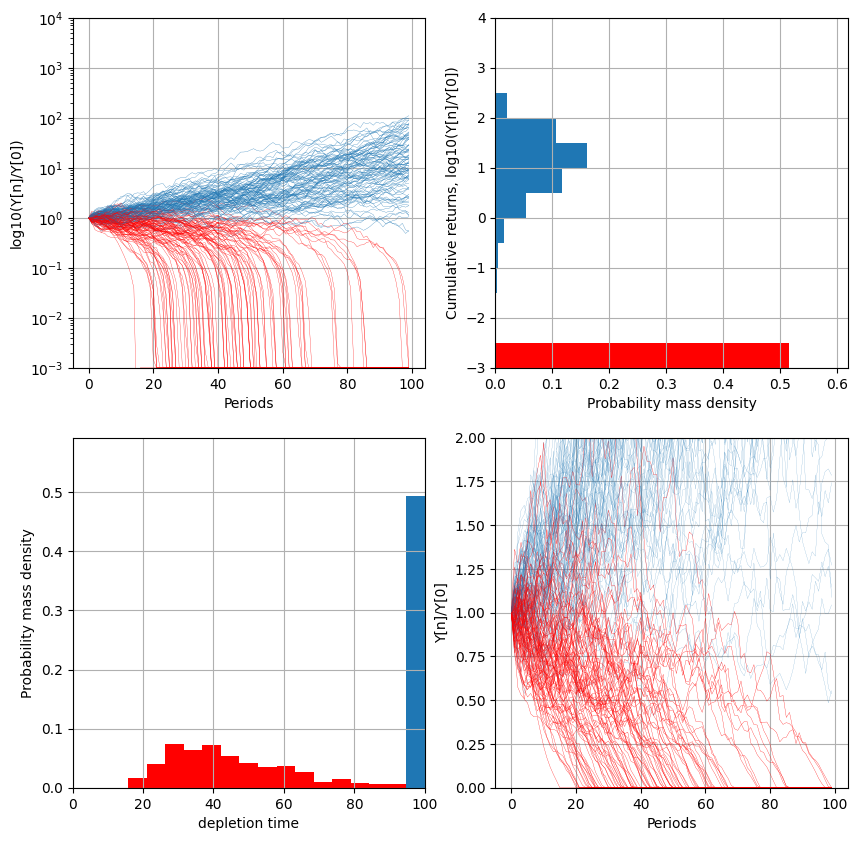

In [2]:
#> Parameters
mu, sigma, C = .045, .10, -.04
x0 = 1.

rng_params = {'loc': mu, 'scale': sigma, 'size': nt}

#> End values, max drawdowns
x_end = np.zeros(nreal)
depletion_times = np.zeros(nreal)
n_ruins = 0

fig, ax = plt.subplots(2,2, figsize=(10, 10))
for ireal in np.arange(nreal):

    #> 1-period returns of the 2 assets
    r = rng(**rng_params)

    #> Rebalanced portfolio
    x = np.zeros(nt);  x[0] = x0
    for ix in np.arange(1,nt):
        x[ix] = x[ix-1] + r[ix-1] * x[ix-1] + C

    #> Ruin condition, when portfolio goes to zero
    neg_indices = np.where(x < 0)[0]
    if ( neg_indices.size > 0 ):
      time_of_depletion = neg_indices[0]
      x[time_of_depletion:] =  x0 * 10**wealth_ruin_exp
      n_ruins += 1
    else:
      time_of_depletion = nt

    #> End values
    x_end[ireal] = x[-1]
    depletion_times[ireal] = time_of_depletion

    #> Plot time-history
    if ( ireal % 10 == 0 ):
        lw = .2 #
        color = plt.cm.tab10.colors[0] if time_of_depletion == nt  else 'red'
        ax[0,0].semilogy(tv, x/x[0], color=color, lw=lw) # , color=plt.cm.tab10.colors[0])
        ax[1,1].plot(tv, x/x[0], color=color, lw=.1 * ( time_of_depletion == nt ) + .2 * ( time_of_depletion < nt ))

#> Exponents of 10 of cumulative return for plots
minret_plot = wealth_ruin_exp
maxret_plot = np.ceil( (mu-sigma**2/2)*nt * 2 * np.log10(np.exp(1)) )

ax[0,0].set_ylabel("log10(Y[n]/Y[0])")
ax[0,0].set_xlabel("Periods")
ax[0,0].set_ylim([10**minret_plot, 10**maxret_plot])   # e^at = (10^(log10(e)))^at
ax[0,0].grid()

dbins = .5
bins = np.arange(minret_plot, maxret_plot, dbins)
counts, bins, patches = ax[0,1].hist(np.log10(x_end), bins=bins, orientation='horizontal', density=False)
# Modify hist() patches to get probability of ranges, like a discrete r.v.
total_count = counts.sum()
probs = counts/total_count
for prob, patch in zip(probs, patches):
    patch.set_width(prob)
patches[0].set_facecolor('red')

ax[0,1].set_ylabel("Cumulative returns, log10(Y[n]/Y[0])")
ax[0,1].set_xlabel("Probability mass density")
ax[0,1].set_xlim([0,1.2 * np.max(probs)])
ax[0,1].set_ylim([minret_plot, maxret_plot])
ax[0,1].grid()

counts, bins, patches = ax[1,0].hist(depletion_times, bins=np.linspace(0,nt,20), density=False, color='red')
ax[1,0].set_ylabel("Probability mass density")
ax[1,0].set_xlabel("depletion time")
ax[1,0].grid()
total_count = counts.sum()
probs = counts/total_count
for prob, patch in zip(probs, patches):
    patch.set_height(prob)
patches[-1].set_facecolor(plt.cm.tab10.colors[0])
ax[1,0].set_xlim([0, nt])
ax[1,0].set_ylim([0, 1.2*np.max(probs)])

ax[1,1].set_ylabel("Y[n]/Y[0]")
ax[1,1].set_xlabel("Periods")
ax[1,1].set_ylim([0, 2*x0])   # e^at = (10^(log10(e)))^at
ax[1,1].grid()


### Dollar Cost Averaging (DCA)

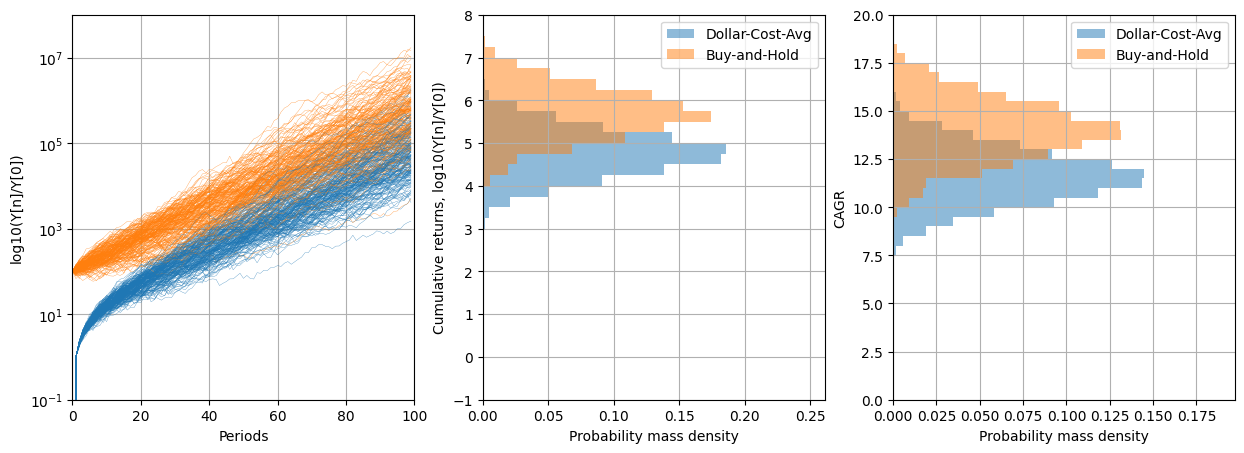

In [3]:
#> Parameters
mu, sigma, C = .10, .15, .04
x0 = .0
x0_bah = C * nt

rng_params = {'loc': mu, 'scale': sigma, 'size': nt}

#> End values, max drawdowns
x_end = np.zeros(nreal)       # Dollar-Cost-Avg (DCA), Ita: PAC
x_bah_end = np.zeros(nreal)   # Buy-and-Hold (BAH)   , Ita: PIC

fig, ax = plt.subplots(1,3, figsize=(15, 5))
for ireal in np.arange(nreal):

    #> 1-period returns of the 2 assets
    r = rng(**rng_params)

    #> Rebalanced portfolio
    x = np.zeros(nt);  x[0] = x0
    for ix in np.arange(1,nt):
        x[ix] = x[ix-1] + r[ix-1] * x[ix-1] + C

    x_bah = np.zeros(nt);  x_bah[0] = x0_bah
    x_bah[1:] = x_bah[0] * np.cumprod(1+r[1:])

    #> End values
    x_end[ireal]     = x[-1]
    x_bah_end[ireal] = x_bah[-1]

    #> Plot time-history
    if ( ireal % 10 == 0 ):
        ax[0].semilogy(tv,     x/C, lw=.2 , color=plt.cm.tab10.colors[0])
        ax[0].semilogy(tv, x_bah/C, lw=.2 , color=plt.cm.tab10.colors[1])


#> Exponents of 10 of cumulative return for plots
minret_plot = -1
maxret_plot = np.ceil( (mu-sigma**2/2)*nt * 2. * np.log10(np.exp(1)) )

ax[0].set_ylabel("log10(Y[n]/Y[0])")
ax[0].set_xlabel("Periods")
ax[0].set_xlim([0, nt])
ax[0].set_ylim([10**minret_plot, 10**maxret_plot])   # e^at = (10^(log10(e)))^at
ax[0].grid()

dbins = .25
bins = np.arange(minret_plot, maxret_plot, dbins)
counts, bins, patches = ax[1].hist(np.log10(x_end/C), bins=bins, orientation='horizontal', density=False, color=plt.cm.tab10.colors[0], alpha=.5, label='Dollar-Cost-Avg')
# Modify hist() patches to get probability of ranges, like a discrete r.v.
total_count = counts.sum()
probs = counts/total_count
for prob, patch in zip(probs, patches):
    patch.set_width(prob)
counts, bins, patches = ax[1].hist(np.log10(x_bah_end/C), bins=bins, orientation='horizontal', density=False, color=plt.cm.tab10.colors[1], alpha=.5, label='Buy-and-Hold')
# Modify hist() patches to get probability of ranges, like a discrete r.v.
total_count = counts.sum()
probs = counts/total_count
for prob, patch in zip(probs, patches):
    patch.set_width(prob)

ax[1].set_ylabel("Cumulative returns, log10(Y[n]/Y[0])")
ax[1].set_xlabel("Probability mass density")
ax[1].set_xlim([0,1.5 * np.max(probs)])
ax[1].set_ylim([minret_plot, maxret_plot])
ax[1].legend()
ax[1].grid()

#>
dbins = .5
bins = np.arange(0.,30.,dbins)
counts, bins, patches = ax[2].hist(((x_end/C)**(1/nt)-1)*100, bins=bins, orientation='horizontal', density=False, color=plt.cm.tab10.colors[0], alpha=.5, label='Dollar-Cost-Avg')
# Modify hist() patches to get probability of ranges, like a discrete r.v.
total_count = counts.sum()
probs = counts/total_count
for prob, patch in zip(probs, patches):
    patch.set_width(prob)
counts, bins, patches = ax[2].hist(((x_bah_end/C)**(1/nt)-1)*100, bins=bins, orientation='horizontal', density=False, color=plt.cm.tab10.colors[1], alpha=.5, label='Buy-and-Hold')
# Modify hist() patches to get probability of ranges, like a discrete r.v.
total_count = counts.sum()
probs = counts/total_count
for prob, patch in zip(probs, patches):
    patch.set_width(prob)

ax[2].set_ylabel("CAGR")
ax[2].set_xlabel("Probability mass density")
ax[2].set_xlim([0, 1.5*np.max(probs)])
ax[2].set_ylim([0, 20])
ax[2].legend()
ax[2].grid()
